# Detection and Classification fruits: Apple and Orange

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!rm -rf Classification_Apple_vs_Orange

In [4]:
!mkdir -p Classification_Apple_vs_Orange/data

In [5]:
!cd Classification_Apple_vs_Orange

## Steps
1. Download dataset from kaggle using `opendataset`
2. Pre-processing data from dataset
2. Build `CustomDataset` class
3. Build `transforms`
4. Split dataset into train data and test data
5. Convert data to `Dataloader`
6. Select/Build neural network
7. Test model and `CustomDataset`
8. Build train and test function
9. Select loss function and optimizer
10. Train model
11. Evaluate model
12. Train with diffrent neural network.

## Step 1: Download dataset
**Datasets**:
- https://www.kaggle.com/datasets/sriramr/apples-bananas-oranges

More data if model isn't good:
- https://www.kaggle.com/datasets/balraj98/apple2orange-dataset?select=metadata.csv




In [6]:
!pip install -q opendatasets

In [7]:
def is_dir_empty(dir_path):
  return not any(dir_path.iterdir())

In [8]:
import opendatasets as od
from pathlib import Path
root_path = Path('/content/drive/MyDrive/Classification_Apple_vs_Orange')
image_path = root_path / 'data/fruits'
if not image_path.is_dir():
  print(f'Create directory {image_path}...')
  image_path.mkdir(parents=True, exist_ok=True)
if is_dir_empty(image_path):
  print(f'Downloading data into {image_path}...')
  od.download('https://www.kaggle.com/datasets/sriramr/apples-bananas-oranges', data_dir=image_path)
else:
  print("Data is downloaded")

Create directory /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits...
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: 
Your Kaggle username: genkikuro
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sriramr/apples-bananas-oranges


100%|██████████| 512M/512M [00:12<00:00, 41.6MB/s]


## Step 2: Prep-processing data

In [9]:
!mkdir /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples
!mkdir /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/oranges

In [10]:
!mv /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples-bananas-oranges/original_data_set/freshapples /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/
!mv /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples-bananas-oranges/original_data_set/rottenapples /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples

In [11]:
!mv /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples-bananas-oranges/original_data_set/freshoranges /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/oranges
!mv /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples-bananas-oranges/original_data_set/rottenoranges /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/oranges

In [12]:
!rm -rf /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples-bananas-oranges

In [13]:
import os
def walk_through_dir(dir_path):
  image_paths = []
  for dir_path, dir_names, file_names in os.walk(dir_path):
    if file_names:
      print(f'There are {len(dir_names)} directories and {len(file_names)} images in {dir_path}')
      for file_name in file_names:
        path = os.path.join(dir_path, file_name)
        image_paths.append(path)
  return image_paths

In [14]:
image_path_list = walk_through_dir(image_path)

There are 0 directories and 232 images in /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples
There are 0 directories and 328 images in /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/rottenapples
There are 0 directories and 206 images in /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/oranges/freshoranges
There are 0 directories and 222 images in /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/oranges/rottenoranges


In [15]:
image_path_list[:10]

['/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Screen Shot 2018-06-08 at 4.59.36 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Screen Shot 2018-06-08 at 4.59.49 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Screen Shot 2018-06-08 at 4.59.57 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Screen Shot 2018-06-08 at 5.00.03 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Screen Shot 2018-06-08 at 5.00.12 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Screen Shot 2018-06-08 at 5.00.18 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Scr

In [16]:
len(image_path_list)

988

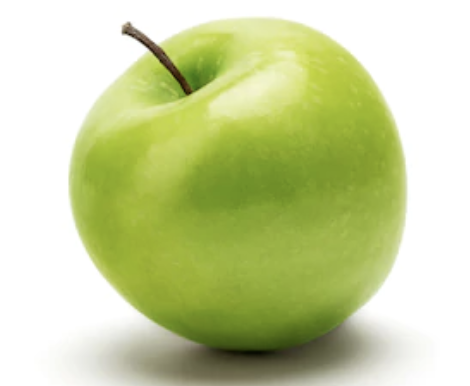

In [17]:
from PIL import Image

image = Image.open(image_path_list[1])
image

In [18]:
def find_classes(target_dir):
    classes = sorted(entry.name for entry in os.scandir(target_dir) if entry.is_dir())
    if not classes:
      raise FileNotFoundError(f"Couldn't find any class name in {target_dir}, please check your input dir!")
    cls_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    return classes, cls_to_idx

find_classes(image_path)

(['apples', 'oranges'], {'apples': 0, 'oranges': 1})

In [19]:
Path(image_path_list[1]).parent.parent.stem

'apples'

## Step 3: Build `FruitsDataset` class

In [20]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path

In [21]:
class FruitsDataset(Dataset):
  def __init__(self, target_dir, transformer:transforms=None):
    self.image_paths = self._walk_through_dir(target_dir)
    # self.image_paths = [Path(p) for p in target_dir]
    self.transform = transformer
    self.classes, self.cls_to_idx = self._find_classes(target_dir)

  def _walk_through_dir(self, target_dir):
    dir_paths = [dir_path for dir_path, _, file_names in os.walk(target_dir) if file_names]
    image_paths = []
    for path in dir_paths:
      image_paths += Path(path).glob("*.png")
    if not image_path:
      raise FileNotFoundError(f"Couldn't find any images in {target_dir}, please check your input dir!")
    return image_paths

  def _find_classes(self, target_dir):
    classes = sorted(entry.name for entry in os.scandir(target_dir) if entry.is_dir())
    if not classes:
      raise FileNotFoundError(f"Couldn't find any class name in {target_dir}, please check your input dir!")
    cls_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    return classes, cls_to_idx

  def _load_image(self, index):
    image = Image.open(self.image_paths[index])
    return image.convert('RGB')

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image = self._load_image(index)
    class_name = self.image_paths[index].parent.parent.stem
    cls_to_idx = self.cls_to_idx[class_name]
    if self.transform:
      image = self.transform(image)
    return image, cls_to_idx

## Step 4: Build `transform`

In [22]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Step 5: Split train data and test data

In [23]:
train_rate = 0.8
from sklearn.model_selection import train_test_split
train_paths, test_paths = train_test_split(image_path_list, train_size=train_rate, random_state=42)

import pandas as pd
pd.Series({
    "Training samples:": len(train_paths),
    "Test samples:": len(test_paths)
}).to_frame().style.hide(axis='columns')

Training samples:,790
Test samples:,198


In [ ]:
# train_paths[:5]

['/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/oranges/rottenoranges/Screen Shot 2018-06-12 at 11.30.06 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Screen Shot 2018-06-08 at 5.29.24 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/rottenapples/Screen Shot 2018-06-07 at 2.40.13 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples/freshapples/Screen Shot 2018-06-08 at 5.06.19 PM.png',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/oranges/rottenoranges/Screen Shot 2018-06-12 at 11.31.48 PM.png']

In [ ]:
# Path(train_paths[2]).name

'Screen Shot 2018-06-07 at 2.40.13 PM.png'

In [ ]:
# image_path

PosixPath('/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits')

In [151]:
# from pathlib import Path

# # Define the full path and the base directory
# full_path = Path(train_paths[200])

# # Extract the relative path
# relative_path = full_path.relative_to(image_path)

# print(f"Relative path: /{relative_path}")
# print(f'Parent: {relative_path.parent}')
# print(f'Parent parent: {relative_path.parent.parent}')

Relative path: /oranges/rottenoranges/Screen Shot 2018-06-12 at 11.23.54 PM.png
Parent: oranges/rottenoranges
Parent parent: oranges


In [24]:
!mkdir /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/train
!mkdir /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/test

### Create train and test dir

In [25]:
import shutil
train_dir = '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/train'
test_dir = '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/test'

for path in (train_paths):
  relative_path = Path(path).relative_to(image_path)
  train_path_parent = Path(train_dir) / relative_path
  os.makedirs(train_path_parent.parent, exist_ok=True)
  shutil.copy(path, train_path_parent)
for path in test_paths:
  relative_path = Path(path).relative_to(image_path)
  test_path_parent = Path(test_dir) / relative_path
  os.makedirs(test_path_parent.parent, exist_ok=True)
  shutil.copy(path, test_path_parent)


In [26]:
train_dir, test_dir

('/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/train',
 '/content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/test')

In [27]:
!rm -rf /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/apples
!rm -rf /content/drive/MyDrive/Classification_Apple_vs_Orange/data/fruits/oranges

In [28]:
# data = FruitsDataset(image_path, transformer=transform)
train_data = FruitsDataset(train_dir, transformer=transform)
test_data = FruitsDataset(test_dir, transformer=transform)

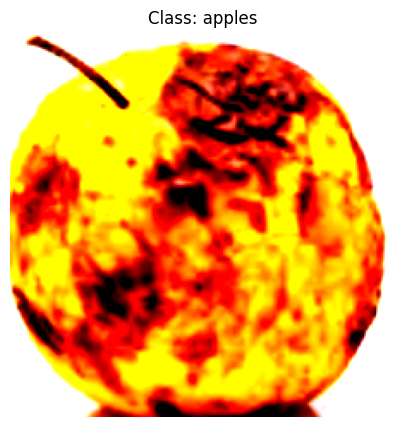

In [29]:
import matplotlib.pyplot as plt
import random

random_idx = random.randint(0, len(train_data))
image, cls_to_idx = train_data[random_idx]

plt.figure(figsize=(5, 5))
plt.imshow(image.permute(1,2,0))
plt.title(f'Class: {train_data.classes[cls_to_idx]}')
plt.axis('off')
plt.show()

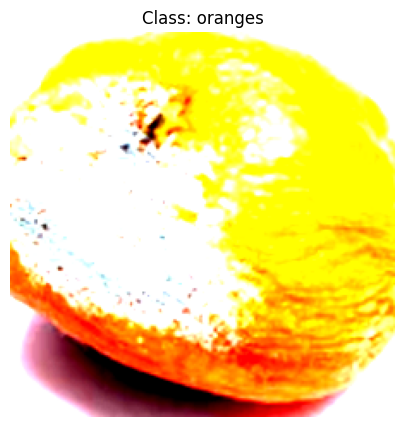

In [30]:
import matplotlib.pyplot as plt
import random

random_idx = random.randint(0, len(test_data))
image, cls_to_idx = train_data[random_idx]

plt.figure(figsize=(5, 5))
plt.imshow(image.permute(1,2,0))
plt.title(f'Class: {train_data.classes[cls_to_idx]}')
plt.axis('off')
plt.show()

In [31]:
train_data.classes

['apples', 'oranges']

## Step 6: Convert data to Dataloader

In [32]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 2

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, num_workers=num_workers)

Image shape: torch.Size([32, 3, 224, 224]), label: torch.Size([32])


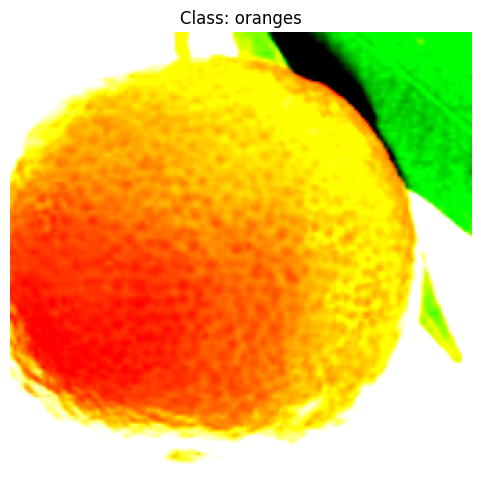

In [33]:
image, label = next(iter(train_dataloader))
print(f'Image shape: {image.shape}, label: {label.shape}')

plt.figure(figsize=(6,6))
plt.imshow(torch.permute(image[0], (1,2,0)))
plt.title(f'Class: {train_data.classes[label[0]]}')
plt.axis('off')
plt.show()